In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf


# Song List

   This file contains the information of all songs in the MSD dataset

In [5]:
songs_list = pd.read_csv('song_data.csv')
songs_list.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


# EDA

  
  

In [9]:
!wget 'https://static.turi.com/datasets/millionsong/10000.txt'

--2020-04-30 23:47:11--  https://static.turi.com/datasets/millionsong/10000.txt
Resolving static.turi.com (static.turi.com)... 99.86.47.58, 99.86.47.112, 99.86.47.82, ...
Connecting to static.turi.com (static.turi.com)|99.86.47.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124114908 (118M) [text/plain]
Saving to: ‘10000.txt’

10000.txt           100%[===================>] 118.36M  2.54MB/s    in 86s     

2020-04-30 23:48:36 (1.38 MB/s) - ‘10000.txt’ saved [124114908/124114908]



In [10]:
df=pd.read_table('10000.txt',header=None,names=['user_id', 'song_id', 'listen_count'])

In [11]:
df.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [12]:
df.count()

user_id         2000000
song_id         2000000
listen_count    2000000
dtype: int64

In [13]:
df.listen_count.max()

2213

The first thing that we notice is that we have no concept of "rating" in our data. All we have are the play counts of various songs. This is a well known problem in the case of recommendation engines and is called the "implicit feedback" problem. There are many ways to solve this problem but we will look at a very simple and intuitive solution. We will replace the play count with a fractional play count. The logic being that this will measure the strength of "likeness" for a song in the range of [0,1].

In [14]:
user_total_listen = df[['user_id','listen_count']].groupby('user_id').sum()
user_total_listen.rename(columns={'listen_count':'total_listen_count'},inplace=True)
df_merged = pd.merge(df,user_total_listen, how = 'left', on = 'user_id')
df_merged['frac_rating'] = (df_merged['listen_count']/df_merged['total_listen_count'])*100

In [15]:
 display(df_merged)

,user_id,song_id,listen_count,total_listen_count,frac_rating
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,71,1.408451
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,71,2.816901
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,71,1.408451
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,71,1.408451
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,71,1.408451
...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,128,1.562500
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,128,3.125000
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,128,2.343750
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,128,0.781250


In [16]:
u_users = df_merged.user_id.unique()
u_songs = df_merged.song_id.unique()

In [17]:
print(u_users.shape)
u_users

(76353,)


array(['b80344d063b5ccb3212f76538f3d9e43d87dca9e',
       '85c1f87fea955d09b4bec2e36aee110927aedf9a',
       'bd4c6e843f00bd476847fb75c47b4fb430a06856', ...,
       'a955513fb89fdb0d5e8437a5cf8a9b3a0abad4d5',
       '276e43ad698705e5011e5091f367d951b21246f5',
       'd8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92'], dtype=object)

In [18]:
print(u_songs.shape)
u_songs

(10000,)


array(['SOAKIMP12A8C130995', 'SOBBMDR12A8C13253B', 'SOBXHDL12A81C204C0',
       ..., 'SOXWEPM12AB0181694', 'SOGYQGZ12AB017E08A',
       'SOPBPHJ12AAF3B59B6'], dtype=object)

In [19]:
df2 = df_merged[['user_id','song_id','frac_rating']].copy()

In [20]:


from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
le2 = LabelEncoder()

le1.fit(u_users)
le2.fit(u_songs)


df2.user_id = le1.transform(df2.user_id)
df2.song_id = le2.transform(df2.song_id)



In [21]:
u_songs_t = le2.transform(u_songs)

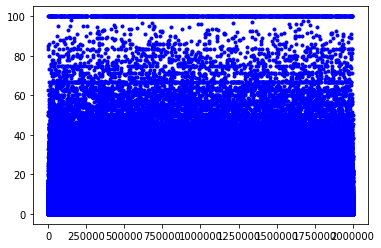

In [22]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(df2.frac_rating,'b.')

In [23]:
max_rating = df2.frac_rating.max()
min_rating = df2.frac_rating.min()

print("max= ",max_rating)
print("min= ",min_rating)

max=  100.0
min=  0.022593764121102578


In [24]:
df2.head()

,user_id,song_id,frac_rating
0,54961,153,1.408451
1,54961,413,2.816901
2,54961,736,1.408451
3,54961,750,1.408451
4,54961,1188,1.408451


# Train and Test Split

In [25]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(df2 ,test_size = 0.2, random_state = 3)


In [26]:
display(train_df.head())
display(test_df.head())


,user_id,song_id,frac_rating
997647,25920,1664,0.803213
31026,36300,8138,1.418440
1230674,47171,3991,0.352113
50783,16369,7416,10.743802
91956,330,8961,0.380228


,user_id,song_id,frac_rating
265057,55450,174,5.844846
812837,48654,4064,3.636364
430100,11365,1863,0.520833
1780104,49493,5176,0.380228
1743551,15572,1566,4.166667


# Training the model


In [27]:

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Concatenate ,Embedding, Input ,Activation,Dense , Dropout, BatchNormalization

from tensorflow.keras.models import Model

def CFmodel(n_users, m_songs):
    
    U = Input(shape = [1] ,name = 'user-input')
    P = Embedding(n_users,150 , name = 'user-emb')(U)
    P = Flatten(name = 'user-flatten')(P)
    
    
    S= Input(shape = [1] ,name = 'song-input')
    Q = Embedding(m_songs,150 ,name = 'song-emb')(S)
    Q = Flatten(name = 'song-flatten')(Q)
    

    X = Concatenate(name = 'merge-cat')([P,Q])
    X = Dropout(rate = 0.05, name = 'drop1')(X)
    X = Dense(units = 10,activation = 'relu', name = 'dense1' )(X)
    X = Dropout(rate = 0.5, name = 'drop2')(X)
    X = Dense(units = 1, name = 'dense2')(X)
    X = Activation('relu',name = 'activation')(X)
    X = X*(max_rating - min_rating) + min_rating


    model = Model(inputs = [U,S] ,outputs = X)
      
    return model



 

In [20]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


The model is complied using mean absolute error and nadam optimizer.
Nadam stands for Nesterov Adam optimizer.
Much like Adam is essentially RMSprop with momentum, Nadam is RMSprop with Nesterov momentum.

In [0]:



strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

with strategy.scope():
  cfm = CFmodel(u_users.shape[0],u_songs.shape[0])
  cfm.compile(loss = 'mae' ,optimizer = 'nadam')

In [22]:
cfm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
song-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-emb (Embedding)            (None, 1, 150)       11452950    user-input[0][0]                 
__________________________________________________________________________________________________
song-emb (Embedding)            (None, 1, 150)       1500000     song-input[0][0]                 
______________________________________________________________________________________________

In [23]:
callbacks = [ ModelCheckpoint('best_weights.h5', save_best_only=True)]

history = cfm.fit([train_df.user_id.values,train_df.song_id.values], train_df.frac_rating.values, epochs=50, validation_split=.1, verbose=1 ,batch_size = 1000 ,callbacks = callbacks)

Epoch 1/50
1440/1440 [==============================] - 17s 12ms/step - loss: 2.6938 - val_loss: 2.2549
Epoch 2/50
1440/1440 [==============================] - 17s 12ms/step - loss: 2.3189 - val_loss: 2.1518
Epoch 3/50
1440/1440 [==============================] - 16s 11ms/step - loss: 2.2259 - val_loss: 2.1112
Epoch 4/50
1440/1440 [==============================] - 16s 11ms/step - loss: 2.1820 - val_loss: 2.0771
Epoch 5/50
1440/1440 [==============================] - 16s 11ms/step - loss: 2.1505 - val_loss: 2.0594
Epoch 6/50
1440/1440 [==============================] - 16s 11ms/step - loss: 2.1284 - val_loss: 2.0421
Epoch 7/50
1440/1440 [==============================] - 16s 11ms/step - loss: 2.1129 - val_loss: 2.0449
Epoch 8/50
1440/1440 [==============================] - 16s 11ms/step - loss: 2.1018 - val_loss: 2.0273
Epoch 9/50
1440/1440 [==============================] - 16s 11ms/step - loss: 2.0919 - val_loss: 2.0266
Epoch 10/50
1440/1440 [==============================] - 16s 11m

In [24]:
history.history

{'loss': [2.6937780380249023,
  2.318911552429199,
  2.2259106636047363,
  2.181952476501465,
  2.1504766941070557,
  2.1283934116363525,
  2.112867832183838,
  2.1018495559692383,
  2.091925621032715,
  2.0858914852142334,
  2.0807316303253174,
  2.074564218521118,
  2.0675158500671387,
  2.0636067390441895,
  2.061347246170044,
  2.0583252906799316,
  2.0534634590148926,
  2.0538220405578613,
  2.051884651184082,
  2.0481016635894775,
  2.046128749847412,
  2.044341564178467,
  2.041382074356079,
  2.039506196975708,
  2.0352590084075928,
  2.0341548919677734,
  2.0322978496551514,
  2.0296425819396973,
  2.0297207832336426,
  2.028974771499634,
  2.0268666744232178,
  2.025714874267578,
  2.025498151779175,
  2.0219359397888184,
  2.022129774093628,
  2.0188443660736084,
  2.017533302307129,
  2.015467882156372,
  2.013873815536499,
  2.0130579471588135,
  2.0113284587860107,
  2.01054048538208,
  2.0070114135742188,
  2.007312774658203,
  2.0039727687835693,
  2.0032079219818115,
 

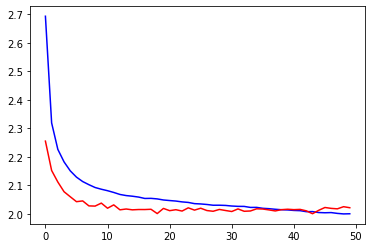

In [25]:

plt.figure()
plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'r-')

# Testing and evaluating

In [0]:
best_cfm = CFmodel(u_users.shape[0],u_songs.shape[0])
best_cfm.load_weights('best_weights.h5')



In [27]:
cfm.evaluate([test_df.user_id.values,test_df.song_id.values], test_df.frac_rating.values,verbose = 1)

12500/12500 [==============================] - 24s 2ms/step - loss: 2.0473


2.047314167022705

In [28]:
preds = best_cfm.predict([test_df.user_id.head(7).values,test_df.song_id.head(7).values])


[print(preds[i],test_df.frac_rating.head(7).values[i]) for i in range(7)]

[0.95334893] 5.844845908607864
[9.424892] 3.6363636363636362
[0.3076262] 0.5208333333333333
[0.02259376] 0.38022813688212925
[3.927102] 4.166666666666666
[0.71317905] 0.4830917874396135
[0.6294554] 0.3389830508474576


[None, None, None, None, None, None, None]

In [0]:
song_emb = best_cfm.get_layer('song-emb')

song_emb_weights = song_emb.get_weights()[0]



In [30]:
song_emb_weights.shape

(10000, 150)

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2,verbose = 1,perplexity = 90)
dimr_song_emb = tsne.fit_transform(song_emb_weights)


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.194s...
[t-SNE] Computed neighbors for 10000 samples in 31.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.184744
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.781578
[t-SNE] KL divergence after 1000 iterations: 2.772605


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


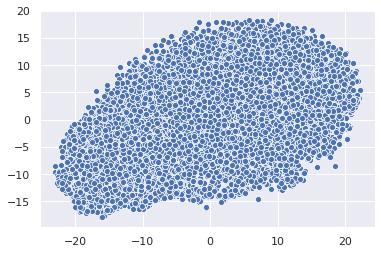

In [32]:
import seaborn as sns

sns.set()

sns.scatterplot(dimr_song_emb[:,0],dimr_song_emb[:,1])

# Recommendation

In [39]:
def recommend(user_idr = 1):

  cfmodel = CFmodel(u_users.shape[0],u_songs.shape[0])
  cfmodel.load_weights('best_weights.h5')

  userr = np.ones(u_songs.shape,dtype = np.int)*user_idr 
  preds_t = cfmodel.predict([userr,u_songs_t])
  
  preds_t = preds_t.flatten()
  
  song_df = pd.DataFrame(data = {'song_id' : u_songs,'score' : preds_t })
  song_df = pd.merge(song_df,songs_list,how = 'left' )
  
  song_df = song_df.sort_values(by = 'score',ascending = False)
  display(song_df[['title','artist_name','year','score']].head(10))

In [42]:
recommend(7876)

,title,artist_name,year,score
5062,Working With Homesick,Homesick James,1991,8.703229
6232,221,keller williams,1998,7.990787
5898,Encore Break,Pearl Jam,2009,7.017760
3283,Clara meets Slope - Hard To Say,Clara Hill,2006,6.804315
8377,In League With Satan,Krisiun,2003,6.183194
1607,I C Love Affair,Gaz Nevada,0,5.931073
8902,Cold Blooded (Acid Cleanse),The fFormula,0,5.771495
3285,Recado Falado (Metrô Da Saudade),Alceu Valença,0,5.694852
8622,MIC (Speak Life Album Version),Sev Statik,0,5.682236
4279,Bros Sto Rimagmeno Spiti (2003 Digital Remaster),George Dalaras,0,5.394083
